In [1]:
using Distributions
using Random, StatsPlots, Plots
using LinearAlgebra
theme(:mute)
using Flux: gradient
using ForwardDiff: derivative
using ProgressMeter
using Optim
using Roots
using JLD2

In [3]:
print("Number of threads used is ",Threads.nthreads())

Number of threads used is 6

# G-and-K Model
The g-and-k model is defined through an inverse cumulative distribution fucntion by 
$$r \in (0,1) = a + b \left(1 + 0.8 \frac{1-\exp(-gz(r))}{1+\exp(-gz(r))}\right) \left(1+z(r)^2\right)^k z(r)$$
with parameters $\theta = (a,b,g,k)$. Here $z(r)$ represents the CDF of a standard Normal distribution.

To sample observations from g-and-k distribution, we can first simulate random numbers from the standard Normal distribution and plug them into the above equation.

In [4]:
# f is defined to transform random variables from standard Normal distribution to samples from g-and-k distribution given the parameter θ.
f(z;θ) = θ[1] + θ[2]*(1+0.8*(1-exp(-θ[3]*z))/(1+exp(-θ[3]*z)))*(1+z^2)^θ[4]*z;

# MCMC Algorithm

### Likelihood function of the g-and-k model
We need to have a likelihood function for MCMC algorithm targetting the g-and-k model. From the definition of the g-and-k distribution, we can see that it is a one-to-one transformation from standard Normal distribution, i.e. $X=f(Z)$. Therefore, the density of $X$ can be defined as 
$$f_X(x) = \phi(z(x)) \left|\frac{dz}{dx}\right| = \phi(z(x)) \cdot 1/\left|\frac{dx}{dz}\right|$$

Hence, we need to define an inversion function that finds the corresponding $z$-value for a given $x$

In [5]:
function inverse(x;θ)
    lower = 0.0; upper = 0.0;
    while (f(lower,θ=θ)-x)*(f(upper,θ=θ)-x) >=0
        lower -= 1.0; upper += 1.0
    end
    return find_zero(z->f(z;θ=θ)-x,(lower,upper))
end
function log_likelihood(x;θ)
    # Find the corresponding z of x
    z = inverse(x,θ=θ)
    # Get the log-derivative
    log_grad = log(abs(derivative(x->f(x,θ=θ),z)))
    return logpdf(Normal(0,1),z) - log_grad
end


log_likelihood (generic function with 1 method)

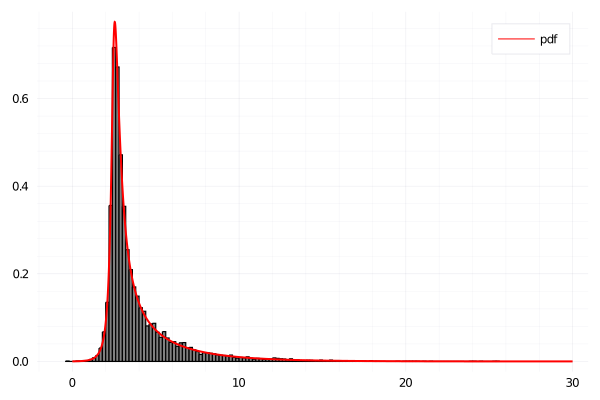

In [6]:
theta_star = [3.0,1.0,2.0,0.5];
histogram(f.(rand(Normal(0,1),10000),θ=theta_star),normalize=true,color=:grey,label="")
plot!(collect(0.0:0.01:30.0),exp.(log_likelihood.(collect(0.0:0.01:30.0),θ=theta_star)),label="pdf",color=:red,linewidth=2.0)

### Random-Walk Metropolis-Hastings (RWM)
We propose a Random-Walk Metropolis-Hastings algorithm to sample from the density $p(\theta|\mathbf{y}) \propto p(\theta)l(\mathbf{y}|\theta)$. We set the prior of $\theta$ to be independent Uniform distributions in the range $[0,10]$. Algorithm 1 outlines the Random-Walk Metropolis-Hastings algorithm.

#### Algorithm 1
Initialize at $\theta_0$. For $t= 1,2,...,N$

<b>Step 1</b>: Propose $\theta' = \theta_{t-1} + \sqrt{\sigma^2 \Sigma} \mathbf{u}$, where $u \sim \mathcal{N}(\mathbf{0},\mathcal{I}_d)$

<b>Step 2</b>: Set $\theta_t = \theta'$ with probablity
$$\alpha(\theta_{t-1},\theta') = \min\left\{1, \frac{p(\theta')}{p(\theta_{t-1})} \frac{l(\mathbf{y}|\theta')}{l(\mathbf{y}|\theta_{t-1})}\right\}$$
<b>Step 3</b>: Otherwise, set $\theta_t = \theta_{t-1}$

In [7]:
RWM_logPrior(θ) = sum(logpdf.(Uniform(0,10),θ))
function RWM(N,Σ,σ;y=ystar,θ0=rand(Uniform(0,10),4))
    C = length(θ0)
    Output = zeros(N,C)
    Output[1,:] = θ0
    AcceptanceProb = 0
    @showprogress 1 "Computing.." for t = 2:N
        theta_proposal = rand(MultivariateNormal(Output[t-1,:],σ*Σ))
        log_alpha = min(0,RWM_logPrior(theta_proposal)-RWM_logPrior(Output[t-1,:]) + 
            sum(log_likelihood.(y,θ=theta_proposal))-sum(log_likelihood.(y,θ=Output[t-1,:])))
        logu = log(rand(Uniform(0,1)))
        if logu < log_alpha
            Output[t,:] = theta_proposal
            AcceptanceProb += 1
        else
            Output[t,:] = Output[t-1,:]
        end
    end
    return (Sample=Output,AcceptanceProb=AcceptanceProb/(N-1))
end

RWM (generic function with 1 method)

In [8]:
theta_star= [3.0,1.0,2.0,0.5];
Random.seed!(123);
zstar = rand(Normal(0,1),20);
ystar = f.(zstar,θ=theta_star);

In [12]:
@load "RWM_COV.jld2" RWM_Σ
RWM_RES,RWM_AcceptanceProb = RWM(100000,RWM_Σ,0.2);

Computing..100%|████████████████████████████████████████| Time: 0:00:32


In [13]:
p1=plot(RWM_RES[:,1],label="",xlabel="Iteration",ylabel="a",linewidth=0.5);hline!([theta_star[1]],label="");
p2=density(RWM_RES[20001:end,1],label="",xlabel="a",ylabel="density");vline!([theta_star[1]],label="");
p3=plot(RWM_RES[:,2],label="",xlabel="Iteration",ylabel="b",linewidth=0.5);hline!([theta_star[2]],label="");
p4=density(RWM_RES[20001:end,2],label="",xlabel="b",ylabel="density");vline!([theta_star[2]],label="");
p5=plot(RWM_RES[:,3],label="",xlabel="Iteration",ylabel="g",linewidth=0.5);hline!([theta_star[3]],label="");
p6=density(RWM_RES[20001:end,3],label="",xlabel="g",ylabel="density");vline!([theta_star[3]],label="");
p7=plot(RWM_RES[:,4],label="",xlabel="Iteration",ylabel="k",linewidth=0.5);hline!([theta_star[4]],label="");
p8=density(RWM_RES[20001:end,4],label="",xlabel="k",ylabel="density");vline!([theta_star[4]],label="");
plot(p1,p2,p3,p4,p5,p6,p7,p8,layout=(2,4),size=(1000,500))

In [14]:
RWM_AcceptanceProb

0.24171241712417124

# SMC-ABC Methods
The likelihood function for g-and-k model is analytically intractable and only numerical solutions of it can be obtained. There are many models in which the likelihood functions are really expensive or just impossible to obtain while generating data sets by the likelihood function is rather simple and cheap. In this case, we turn to use ABC method to find an approximate of the posterior $p(\theta|\mathbf{y})$, which is given by

$$p_{\epsilon}(\theta,x|\mathbf{y}) \propto p(\theta) l(x|\theta) \mathbb{I}(d(\mathbf{y},x)<\epsilon)$$

In the SMC-ABC setup, we will define a sequence of $\epsilon$'s, say $\epsilon_1>\epsilon_2>...$ and define

$$\pi_t(\theta_t,x_t) \propto p(\theta_t) l(x_t|\theta_t) \mathbb{I}(d(\mathbf{y},x_t)<\epsilon_t)$$

Adopting the Sequential Monte Carlo (SMC) sampler by Del Moral, the incremental weights at the $t+1$-th SMC step will be given by

$$w_{t+1} := \frac{\pi_{t+1}(\theta_{t+1},x_{t+1})\mathcal{L}_{t}(\theta_t,x_t|\theta_{t+1},x_{t+1})}{\pi_t(\theta_t,x_t)K_{t+1}(\theta_{t+1},x_{t+1}|\theta_t,x_t)}$$

In later implementation, $\mathcal{L}_{t}$ is choosen so that $\pi_{t+1}$ is kept invariant under $K_{t+1}$ and $\mathcal{L}_{t}$, i.e. 
$$\pi_{t+1}(\theta_t,x_t)K_{t+1}(\theta_{t+1},x_{t+1}|\theta_t,x_t) = \pi_{t+1}(\theta_{t+1},x_{t+1})\mathcal{L}_{t}(\theta_t,x_t|\theta_{t+1},x_{t+1})$$

Then, $w_{t+1}$ will be simplified to 
$$w_{t+1} = \frac{\pi_{t+1}(\theta_t,x_t)}{\pi_{t}(\theta_t,x_t)}=\frac{\mathbb{I}(d(\mathbf{y},x_t)<\epsilon_{t+1})}{\mathbb{I}(d(\mathbf{y},x_t)<\epsilon_t)}$$


## Naive SMC-ABC (N-SMC-ABC)
For the Naive-SMC-ABC method, the proposal kernel $K_{n+1}$ we used is a local Metropolis-Hastings kernel. At the $t+1$-th SMC step,

<b> Step 1</b>:Propose
$$\theta' = \theta_t + \sqrt{\sigma^2\Sigma} \mathbf{u}$$
with $\mathbf{u} \sim \mathcal{N}(\mathbf{0},\mathcal{I}_d)$

<b> Step 2</b>:Sample $x' \sim l(\cdot|\theta')$

<b> Step 3 </b>: Set $\theta_{t+1} = \theta'$ with probability

$$\alpha(\theta_{t},\theta') := \min\left\{1,\frac{\pi_{t+1}(\theta',x')}{\pi_{t+1}(\theta_t,x_t)}\frac{q(\theta_t|\theta')l(x_t|\theta_t)}{q(\theta'|\theta_{t})l(x'|\theta')}\right\} = \min\left\{1,\frac{p(\theta')}{p(\theta_t)}\frac{q(\theta_t|\theta')}{q(\theta'|\theta_{t})}\frac{\mathbb{I}(d(\mathbf{y},x')<\epsilon_{t+1})}{\mathbb{I}(d(\mathbf{y},x_t)<\epsilon_{t+1})}\right\}$$

In [15]:
Naive_Dist(x) = norm(sort(x) .- sort(ystar));
Naive_logPrior(θ) = sum(logpdf.(Uniform(0,10),θ));

In [16]:
function Naive_SMC_ABC_LocalMH(θ0,x0,ϵ;Σ,σ,NoData)
    theta_proposal = rand(MultivariateNormal(θ0,σ*Σ))
    if Naive_logPrior(theta_proposal)==-Inf
        return (θ0,x0,0)
    else
        x_proposal = f.(rand(Normal(0,1),NoData),θ=theta_proposal)
        if Naive_Dist(x_proposal) < ϵ
            return (theta_proposal,x_proposal,1)
        else
            return (θ0,x0,0)
        end
    end
end

Naive_SMC_ABC_LocalMH (generic function with 1 method)

In [17]:
function Naive_SMC_ABC(N,T,NoData,U,σ,λ)
    THETA    = zeros(4,N,T+1);
    X        = zeros(NoData,N,T+1);
    EPSILON  = zeros(T+1);
    DISTANCE = zeros(N,T+1);
    WEIGHT   = zeros(N,T+1);
    ANCESTOR = zeros(Int,N,T);
    THETA[:,:,1] = rand(Uniform(0,10),4,N)
    SIGMA    = zeros(T+1)
    SIGMA[1] = σ
    ACCEPTANCE = zeros(T)
    for i = 1:N
        X[:,i,1] = f.(rand(Normal(0,1),NoData),θ=THETA[:,i,1])
        DISTANCE[i,1] = Naive_Dist(X[:,i,1])
    end
    
    WEIGHT[:,1] .= 1/N;
    EPSILON[1]  = findmax(DISTANCE[:,1])[1]
    
    @showprogress 1 "Computing.." for t = 1:T
        accepted = 0
        ANCESTOR[:,t] = vcat(fill.(1:N,rand(Multinomial(N,WEIGHT[:,t])))...);
        if length(unique(DISTANCE[:,t]))<Int(U*N)
            EPSILON[t+1] = EPSILON[t]
        else
            EPSILON[t+1] = sort(unique(DISTANCE[:,t]))[Int(U*N)]
        end
        WEIGHT[:,t+1] = (DISTANCE[ANCESTOR[:,t],t] .< EPSILON[t+1])/sum(DISTANCE[ANCESTOR[:,t],t] .< EPSILON[t+1])
        Σ = cov(THETA[:,findall(WEIGHT[:,t].>0),t],dims=2)+1e-8*I
        Threads.@threads for i = 1:N
            newθ,newx,dec= Naive_SMC_ABC_LocalMH(THETA[:,ANCESTOR[i,t],t],X[:,ANCESTOR[i,t],t],EPSILON[t+1],Σ=Σ,σ=SIGMA[t],NoData=NoData)
            accepted += dec
            THETA[:,i,t+1] = newθ;
            X[:,i,t+1] = newx;
            DISTANCE[i,t+1] = Naive_Dist(X[:,i,t+1])
        end
        SIGMA[t+1] = exp(log(SIGMA[t]) + λ*(accepted/N-0.234))
        ACCEPTANCE[t] = accepted/N
    end
    return (Theta=THETA,X=X,DISTANCE=DISTANCE,WEIGHT=WEIGHT,EPSILON=EPSILON,SIGMA=SIGMA,ACCEPTANCE=ACCEPTANCE)
end

Naive_SMC_ABC (generic function with 1 method)

In [56]:
Naive_SMC_ABC_RES = Naive_SMC_ABC(20000,1000,20,0.6,0.1,0.2);

Computing..100%|████████████████████████████████████████| Time: 0:00:44


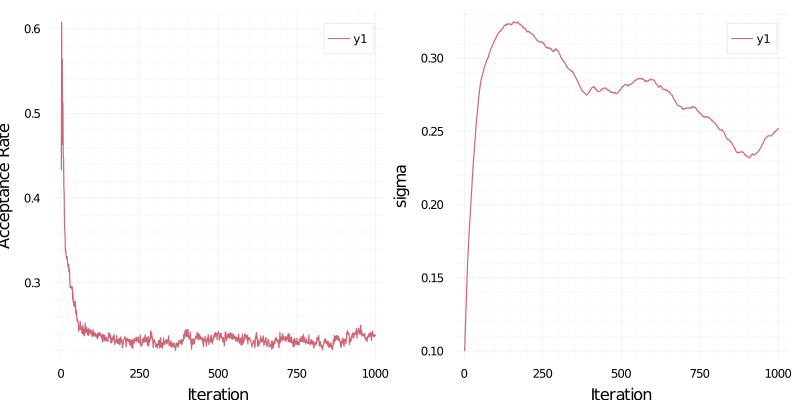

In [57]:
p1 = plot(Naive_SMC_ABC_RES.ACCEPTANCE,xlabel="Iteration",ylabel="Acceptance Rate");
p2 = plot(Naive_SMC_ABC_RES.SIGMA,xlabel="Iteration",ylabel="sigma");
plot(p1,p2,layout=(1,2),size=(800,400))

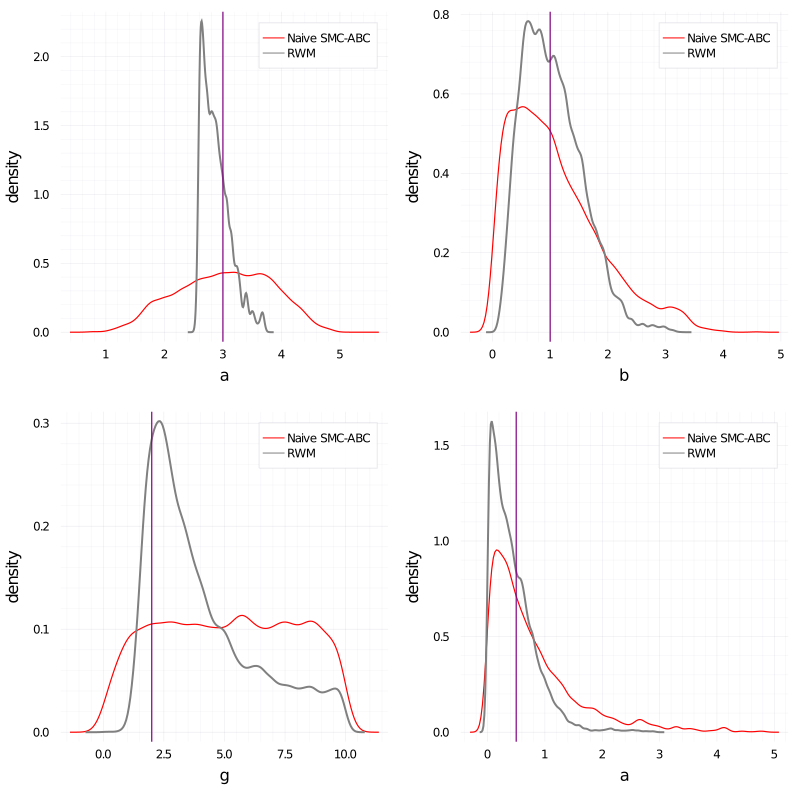

In [58]:
t = 200
p1=density(Naive_SMC_ABC_RES.Theta[1,:,t],label="Naive SMC-ABC",color=:red,xlabel="a",ylabel="density");
density!(RWM_RES[20001:end,1],label="RWM",color=:grey,linewidth=2);
vline!([theta_star[1]],label="",color=:purple);
p2=density(Naive_SMC_ABC_RES.Theta[2,:,t],label="Naive SMC-ABC",color=:red,xlabel="b",ylabel="density");
density!(RWM_RES[20001:end,2],label="RWM",color=:grey,linewidth=2);
vline!([theta_star[2]],label="",color=:purple);
p3=density(Naive_SMC_ABC_RES.Theta[3,:,t],label="Naive SMC-ABC",color=:red,xlabel="g",ylabel="density");
density!(RWM_RES[20001:end,3],label="RWM",color=:grey,linewidth=2);
vline!([theta_star[3]],label="",color=:purple);
p4=density(Naive_SMC_ABC_RES.Theta[4,:,t],label="Naive SMC-ABC",color=:red,xlabel="a",ylabel="density");
density!(RWM_RES[20001:end,4],label="RWM",color=:grey,linewidth=2);
vline!([theta_star[4]],label="",color=:purple);
plot(p1,p2,p3,p4,layout=(2,2),size=(800,800))

## Random-Walk SMC-ABC (RW-SMC-ABC)

In the Naive SMC-ABC algorithm, we need to sample the latents $z$'s at each time. This is wasteful and inefficient. We propose a new type of SMC-ABC algorithm based on the naive implementation. Instead of sampling the latents freshly at each iteration, we keep the previously sampled latents and make perturbations on them. As such, we now target distributions defined on extended space, i.e.

$$\pi_t(\theta_t,z_t,x_t|\mathbf{y}) \propto p(\theta_t,z_t)l(x_t|\theta_t,z_t) \mathbb{I}(d(\mathbf{y},x_t)<\epsilon_t)$$

To simplify notations, we set $\xi_t:= (\theta_t,z_t)$ and $\pi_t(\xi_t,x_t|\mathbf{y}) \propto p(\xi_t) l(x_t|\xi_t)\mathbb{I}(d(\mathbf{y},x_t)<\epsilon_t)$. In the implementation, we still set the priors of $\theta$ to be independent Uniforms in the range $[0,10]$. In addition, we set the priors of the latents to be independent standard Normals.

In [63]:
RW_logPrior(ξ) = sum(logpdf.(Uniform(0,10),ξ[1:4])) + sum(logpdf.(Normal(0,1),ξ[5:end]))
RW_Dist(x) = norm(sort(x) .- sort(ystar));

In [62]:
function RW_SMC_ABC_LocalMH(ξ0,x0,ϵ;Σ,σ)
    xi_proposal = rand(MultivariateNormal(ξ0,σ*Σ))
    u = log(rand(Uniform(0,1)))
    if u> (RW_logPrior(xi_proposal)-RW_logPrior(ξ0))
        return (ξ0,x0,0)
    else
        x_proposal = f.(xi_proposal[5:end],θ=xi_proposal[1:4])
        if RW_Dist(x_proposal) < ϵ
            return (xi_proposal,x_proposal,1)
        else
            return (ξ0,x0,0)
        end
    end
end

RW_SMC_ABC_LocalMH (generic function with 1 method)

In [65]:
function RW_SMC_ABC(N,T,NoData,Threshold,σ,λ)
    XI       = zeros(4+NoData,N,T+1);
    X        = zeros(NoData,N,T+1);
    EPSILON  = zeros(T+1);
    DISTANCE = zeros(N,T+1);
    WEIGHT   = zeros(N,T+1);
    ANCESTOR = zeros(Int,N,T);
    for i = 1:N
        XI[:,i,1] = [rand(Uniform(0,10),4);rand(Normal(0,1),NoData)]
        X[:,i,1]  = f.(XI[5:end,i,1],θ=XI[1:4,i,1])
        DISTANCE[i,1] = RW_Dist(X[:,i,1])
    end
    SIGMA    = zeros(T+1)
    SIGMA[1] = σ
    ACCEPTANCE = zeros(T)
    WEIGHT[:,1] .= 1/N;
    EPSILON[1]  = findmax(DISTANCE[:,1])[1]
    DEC_VEC = zeros(N)
    @showprogress 1 "Computing.." for t = 1:T
        accepted = 0
        ANCESTOR[:,t] = vcat(fill.(1:N,rand(Multinomial(N,WEIGHT[:,t])))...);
        if length(unique(DISTANCE[:,t]))<Int(Threshold*N)
            EPSILON[t+1] = EPSILON[t]
        else
            EPSILON[t+1] = sort(unique(DISTANCE[:,t]))[Int(Threshold*N)]
        end
        WEIGHT[:,t+1] = (DISTANCE[ANCESTOR[:,t],t] .< EPSILON[t+1])/sum(DISTANCE[ANCESTOR[:,t],t] .< EPSILON[t+1])
        Σ = cov(XI[:,findall(WEIGHT[:,t].>0),t],dims=2) + 1e-8*I
        Threads.@threads for i = 1:N
            XI[:,i,t+1],X[:,i,t+1],DEC_VEC[i] = RW_SMC_ABC_LocalMH(XI[:,ANCESTOR[i,t],t],X[:,ANCESTOR[i,t],t],EPSILON[t+1],Σ=Σ,σ=SIGMA[t])
            DISTANCE[i,t+1] = RW_Dist(X[:,i,t+1])
        end
        accepted = mean(DEC_VEC)
        SIGMA[t+1] = exp(log(SIGMA[t]) + λ*(accepted-0.234))
        ACCEPTANCE[t] = accepted
    end
    return (XI=XI,X=X,DISTANCE=DISTANCE,WEIGHT=WEIGHT,EPSILON=EPSILON,SIGMA=SIGMA,ACCEPTANCE=ACCEPTANCE)
end

RW_SMC_ABC (generic function with 1 method)

In [70]:
RW_SMC_ABC_RES = RW_SMC_ABC(20000, 1000, 20, 0.6, 0.1, 0.2);

Computing..100%|████████████████████████████████████████| Time: 0:03:07


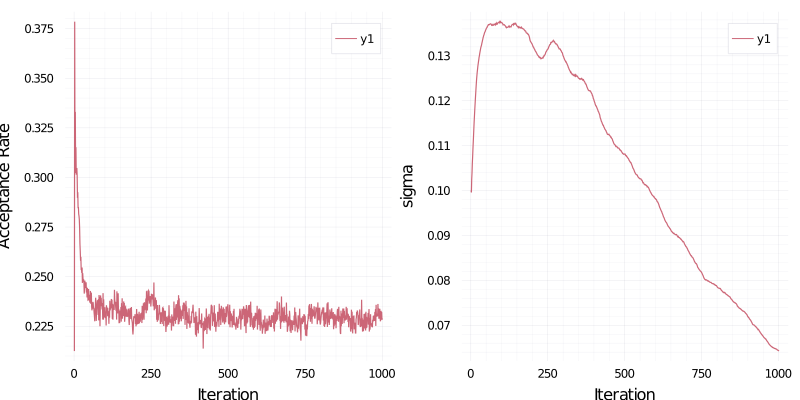

In [71]:
p1 = plot(RW_SMC_ABC_RES.ACCEPTANCE,xlabel="Iteration",ylabel="Acceptance Rate");
p2 = plot(RW_SMC_ABC_RES.SIGMA,xlabel="Iteration",ylabel="sigma");
plot(p1,p2,layout=(1,2),size=(800,400))

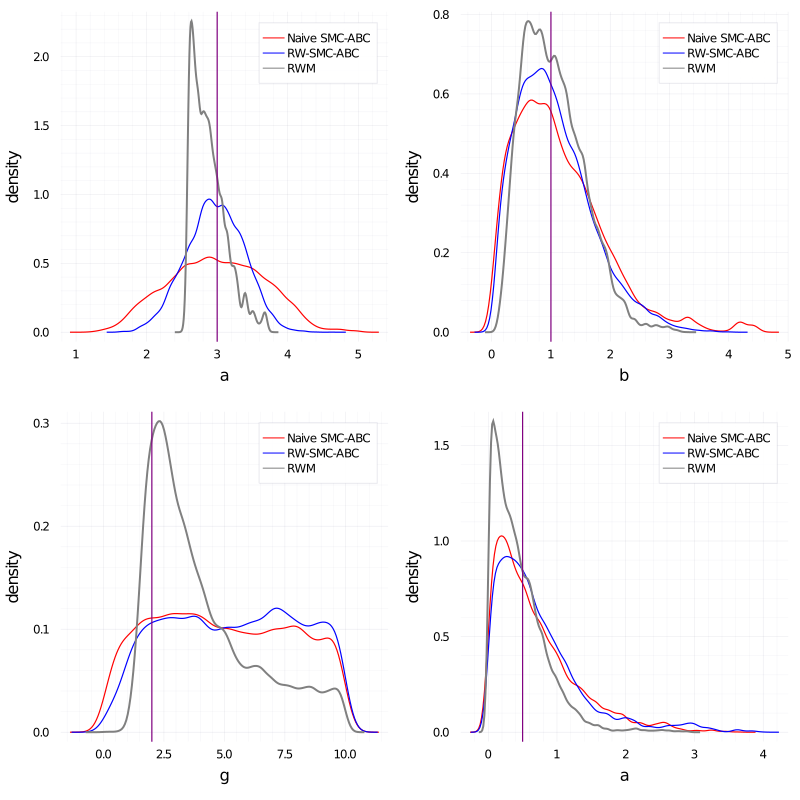

In [72]:
t = 1001
p1=density(Naive_SMC_ABC_RES.Theta[1,:,t],label="Naive SMC-ABC",color=:red,xlabel="a",ylabel="density");
density!(RW_SMC_ABC_RES.XI[1,:,t],label="RW-SMC-ABC",color=:blue);
#density!(Langevin_SMC_ABC_RES2.XI[1,:,t],label="Langevin-SMC-ABC",color=:green);
density!(RWM_RES[20001:end,1],label="RWM",color=:grey,linewidth=2);
vline!([theta_star[1]],label="",color=:purple);
p2=density(Naive_SMC_ABC_RES.Theta[2,:,t],label="Naive SMC-ABC",color=:red,xlabel="b",ylabel="density");
density!(RW_SMC_ABC_RES.XI[2,:,t],label="RW-SMC-ABC",color=:blue);
#density!(Langevin_SMC_ABC_RES2.XI[2,:,t],label="Langevin-SMC-ABC",color=:green);
density!(RWM_RES[20001:end,2],label="RWM",color=:grey,linewidth=2);
vline!([theta_star[2]],label="",color=:purple);
p3=density(Naive_SMC_ABC_RES.Theta[3,:,t],label="Naive SMC-ABC",color=:red,xlabel="g",ylabel="density");
density!(RW_SMC_ABC_RES.XI[3,:,t],label="RW-SMC-ABC",color=:blue);
#density!(Langevin_SMC_ABC_RES2.XI[3,:,t],label="Langevin-SMC-ABC",color=:green);
density!(RWM_RES[20001:end,3],label="RWM",color=:grey,linewidth=2);
vline!([theta_star[3]],label="",color=:purple);
p4=density(Naive_SMC_ABC_RES.Theta[4,:,t],label="Naive SMC-ABC",color=:red,xlabel="a",ylabel="density");
density!(RW_SMC_ABC_RES.XI[4,:,t],label="RW-SMC-ABC",color=:blue);
#density!(Langevin_SMC_ABC_RES2.XI[4,:,t],label="Langevin-SMC-ABC",color=:green);
density!(RWM_RES[20001:end,4],label="RWM",color=:grey,linewidth=2);
vline!([theta_star[4]],label="",color=:purple);
plot(p1,p2,p3,p4,layout=(2,2),size=(800,800))

In [73]:
Unique_RW_SMC_ABC = zeros(1001); Unique_Naive_SMC_ABC=zeros(1001); #Unique_Langevin_SMC_ABC = zeros(201)
for t = 1:1001
    Unique_RW_SMC_ABC[t] = length(unique(RW_SMC_ABC_RES.DISTANCE[findall(RW_SMC_ABC_RES.WEIGHT[:,t].>0.0),t]))
    Unique_Naive_SMC_ABC[t] = length(unique(Naive_SMC_ABC_RES.DISTANCE[findall(Naive_SMC_ABC_RES.WEIGHT[:,t].>0.0),t]))
    #Unique_Langevin_SMC_ABC[t] = length(unique(Langevin_SMC_ABC_RES2.DISTANCE[findall(Langevin_SMC_ABC_RES2.WEIGHT[:,t].>0.0),t]))
end

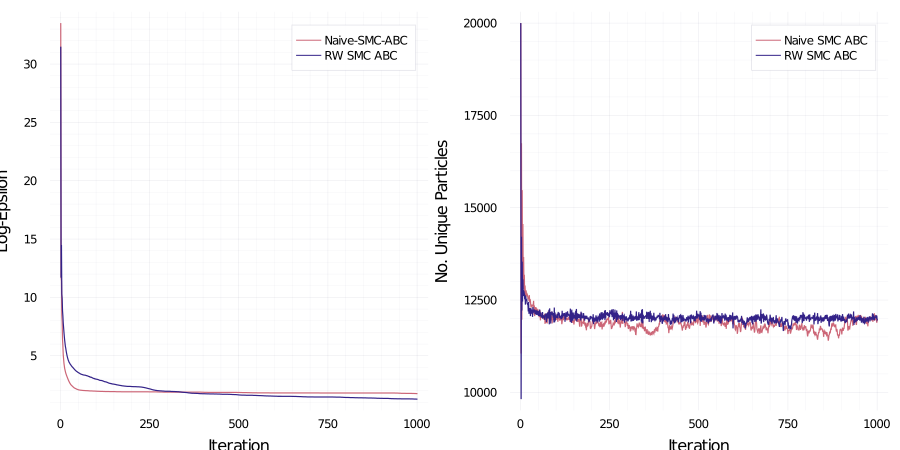

In [75]:
p1 = plot(log.(Naive_SMC_ABC_RES.EPSILON),label="Naive-SMC-ABC",xlabel="Iteration",ylabel="Log-Epsilon");
plot!(log.(RW_SMC_ABC_RES.EPSILON),label="RW SMC ABC");
#plot!(log.(Langevin_SMC_ABC_RES2.EPSILON),label="Langevin SMC ABC");
p2 = plot(Unique_Naive_SMC_ABC,label="Naive SMC ABC",xlabel="Iteration",ylabel="No. Unique Particles")
plot!(Unique_RW_SMC_ABC,label="RW SMC ABC");
#plot!(Unique_Langevin_SMC_ABC,label="Langevin SMC ABC");
plot(p1,p2,layout=(1,2),size=(900,450))

In [76]:
Langevin_logPrior(ξ) = sum(logpdf.(Uniform(0,10),ξ[1:4]))+sum(logpdf.(Normal(0,1),ξ[5:end]))
Langevin_Dist(ξ) = norm(f.(ξ[5:end],θ=ξ[1:4]) .- ystar)
grad(ξ) = normalize(gradient(Langevin_Dist,ξ)[1])

grad (generic function with 1 method)

In [77]:
function Langevin_SMC_ABC_LocalMH(ξ0,ϵ;Σ,σ)
    newξ = rand(MultivariateNormal(ξ0 .- σ/2*Σ*grad(ξ0),σ*Σ))
    forward_proposal_density = logpdf(MultivariateNormal(ξ0 .- σ/2*Σ*grad(ξ0),σ*Σ),newξ)
    backward_proposal_density = logpdf(MultivariateNormal(newξ .- σ/2*Σ* grad(newξ),σ*Σ),ξ0)
    log_propose_ratio = backward_proposal_density - forward_proposal_density
    logPrior_ratio = Langevin_logPrior(newξ)-Langevin_logPrior(ξ0)
    u = log(rand(Uniform(0,1)))
    if u >= logPrior_ratio + log_propose_ratio
        return (ξ0,0,log_propose_ratio,logPrior_ratio)
    else
        if Langevin_Dist(newξ) < ϵ
            return (newξ,1,log_propose_ratio,logPrior_ratio)
        else
            return (newξ,0,log_propose_ratio,logPrior_ratio)
        end
    end
end

Langevin_SMC_ABC_LocalMH (generic function with 1 method)

In [51]:
function Langevin_SMC_ABC(N,T,NoData,Threshold,σ,λ)
    XI       = zeros(4+NoData,N,T+1);
    EPSILON  = zeros(T+1);
    DISTANCE = zeros(N,T+1);
    WEIGHT   = zeros(N,T+1);
    ANCESTOR = zeros(Int,N,T);
    LOGPROPOSAL = zeros(N,T);
    LOGPRIOR = zeros(N,T)
    for i = 1:N
        XI[:,i,1] = [rand(Uniform(0,10),4);rand(Normal(0,1),NoData)]
        DISTANCE[i,1] = Langevin_Dist(XI[:,i,1])
    end
    SIGMA    = zeros(T+1)
    SIGMA[1] = σ
    ACCEPTANCE = zeros(T)
    WEIGHT[:,1] .= 1/N;
    EPSILON[1]  = findmax(DISTANCE[:,1])[1]
    
    @showprogress 1 "Computing.." for t = 1:T
        accepted = 0
        ANCESTOR[:,t] = vcat(fill.(1:N,rand(Multinomial(N,WEIGHT[:,t])))...);
        if length(unique(DISTANCE[:,t]))<Int(Threshold*N)
            EPSILON[t+1] = EPSILON[t]
        else
            EPSILON[t+1] = sort(unique(DISTANCE[:,t]))[Int(Threshold*N)]
        end
        WEIGHT[:,t+1] = (DISTANCE[ANCESTOR[:,t],t] .< EPSILON[t+1])/sum(DISTANCE[ANCESTOR[:,t],t] .< EPSILON[t+1])
        Σ = cov(XI[:,findall(WEIGHT[:,t].>0),t],dims=2) + 1e-8*I
        for i = 1:N
            newξ,dec,logprop,logprior= Langevin_SMC_ABC_LocalMH(XI[:,ANCESTOR[i,t],t],EPSILON[t+1],Σ=Σ,σ=SIGMA[t])
            accepted += dec
            XI[:,i,t+1] = newξ;
            LOGPROPOSAL[i,t] = logprop
            LOGPRIOR[i,t]    = logprior
            DISTANCE[i,t+1] = Langevin_Dist(XI[:,i,t+1])
        end
        SIGMA[t+1] = exp(log(SIGMA[t]) + λ*(accepted/N-0.45))
        ACCEPTANCE[t] = accepted/N
    end
    return (XI=XI,DISTANCE=DISTANCE,WEIGHT=WEIGHT,EPSILON=EPSILON,SIGMA=SIGMA,ACCEPTANCE=ACCEPTANCE,LOGPRIOR=LOGPRIOR,LOGPROPOSAL=LOGPROPOSAL)
end


Langevin_SMC_ABC (generic function with 1 method)

In [10]:
@load "Langevin_SMC_ABC_RES1.jld2" Langevin_SMC_ABC_RES
@load "Langevin_SMC_ABC_RES2.jld2" Langevin_SMC_ABC_RES2

1-element Array{Symbol,1}:
 :Langevin_SMC_ABC_RES2